# Modelling the eclipse profile of PSR J0737-3039A by the magnetosphere of PSR J0737-3039B

Reverse engineering the eclipse light-curve model created by Rene Breton -- based upon the original light-curve model of Lyutikov & Thompson (2005)

In [1]:
import numpy as np
import time
import bilby

import concurrent.futures

from astropy.time import Time
import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt

In [2]:
SEC_PER_DAY = 24*60*60
DEG_TO_RAD = np.pi/180

In [3]:
class model_eclipse(object):
    """
    Parameters
    ----------
    phase_B : ndarray
        Spin phase of B corresponding to each point in the lightcurve.
    orbital_phase : ndarray
        Orbital phase corresponding to each point in the lightcurve.
    flux : ndarray, None
        Flux for each point in the lightcurve.
        If not provided, the array will be filled with zeros, which can be
        useful for testing and theoretical lightcurve calculations.
    flux_err : ndarray, None
        Error for each point in the lightcurve.
        If not provided, the array will be filled with ones, which can be
        useful for testing and theoretical lightcurve calculations.
    """
    
    def __init__(self, phase_B, orbital_phase, flux=None, flux_err=None):
        
        self.n = phase_B.shape[0]
        self.B_max0 = 440.0
        self.r_cool = 0.0
        self.phase_B = phase_B
        self.orbital_phase = orbital_phase
        
        if flux is None:
            self.flux = np.zeros(self.n, dtype=np.float64)
        else:
            self.flux = flux
            
        if flux_err is None:
            self.flux_err = np.ones(self.n, dtype=np.float64)
        else:
            self.flux_err = flux_err
        
            
    def _model(self, theta=45*np.pi/180, phi=60*np.pi/180, chi=30*np.pi/180, nu=0.8, r_min=0.35, upsilon=2., z=-0.5,
              ratio=1., shift_phase_B=0., do_phase=1):
        
        # Placeholder output
        eclipse_model = np.empty(self.n, dtype=np.float64)
        
        # Initialisation
        itot = 500 # number of steps to ajust the position in x
        B_max = self.B_max0 * nu # maximum B-field for synchrotron resonant absorption
        minus_pownu_upsilon = -nu**(-5./3) * upsilon # -upsilon * nu**-5/3 (simplification)
        
        # Calculate phase shift from coordinate transform (may be necessary)
        if do_phase == 1:
            shift_phase_B += phase_on(theta, phi, chi)
            
        # Calculate phase shift from coordinate transform (may be necessary) for -ve value
        if do_phase == -1:
            shift_phase_B -= phase_on(theta, phi, chi)

        for j in range(self.n):
            # Calculate alpha
            alpha = (self.phase_B[j] + shift_phase_B) * 2*np.pi
            
            # Calculate y: x, y & z are expressed in units of R_mag -- R_mag = ratio * 2 pi/360 times orbital distance
            # b/w PSRs A & B
            y = (self.orbital_phase[j] - 0.25) * 360 * ratio
            y2z2 = y**2 + z**2
            
            tau = 0.
            delta_x = 0.
            
            if y2z2 < 1:
                # Calculate initial value of x then step through different values of x
                x = np.sqrt(1 - y2z2)
                # Calculate step size in x
                delta_x = 2 * x/itot
                
                # Position of the magnetic moment in Cartesian coordinates                
                mu_x = ( (np.sin(chi) * np.cos(alpha) * np.cos(theta) + np.cos(chi) * np.sin(theta))*np.cos(phi)
                    - (np.sin(chi) * np.sin(alpha) * np.sin(phi)) )
                mu_y = ( (np.sin(chi) * np.cos(alpha) * np.cos(theta) + np.cos(chi) * np.sin(theta))*np.sin(phi)
                    + (np.sin(chi) * np.sin(alpha) * np.cos(phi)) )
                mu_z = (np.cos(chi) * np.cos(theta)) - (np.sin(chi) * np.cos(alpha) * np.sin(theta))
                
                for i in range(itot):
                    x -= delta_x
                    
                    # radial coordinate
                    r = np.sqrt(x**2 + y2z2)
            
                    if r > self.r_cool:
                        # Calculate cos(theta_mu)
                        cos_theta_mu = (mu_x*x + mu_y*y + mu_z*z) / r
                        
                        # r_max =  max radius of extent for the magnetic field line: r_max = r/sin(theta_mu)^s
                        # If cos_theta_mu**2 == 1, then we're right above the B-field pole & r_max = infinit.
                        # Set r_max = 1.1, so we are out of the magnetosphere -- prevents a divide by zero later
                        if cos_theta_mu**2 == 1:
                            r_max = 1.1
                        else:
                            r_max = r / (1 - cos_theta_mu**2)
                            
                        if (r_max < 1) and (r_max > r_min):
                            # Calculate B-field strength at x
                            B = np.sqrt(1 + 3*cos_theta_mu**4) / r**3
                            
                            if B < B_max:
                                # Calculate angle between the local magnetic field direction and the line-of-sight
                                cos_kappa = (3*cos_theta_mu*x/r - mu_x) / (r**3 * B)
                                
                                if cos_kappa > 1:
                                    cos_kappa = 1
                                elif cos_kappa < -1:
                                    cos_kappa = -1
                                    
                                # Compute the optical depth
                                tau += (B * np.sqrt(1 - cos_kappa**2))**(2./3)

            eclipse_model[j] = np.exp(minus_pownu_upsilon * tau * delta_x)
        return eclipse_model
    
    def model(self, theta=45*np.pi/180, phi=60*np.pi/180, chi=30*np.pi/180, nu=0.8, r_min=0.35, upsilon=2., z=-0.5,
              ratio=1., shift_phase_B=0., do_phase=1):
        """
        Model

        Return the theoretical eclipse lightcurve given some input parameters.

        Parameters
        ----------
        theta : float
            Angle between the spin axis and the orbital angular momentum
            (radians).
            Default: 45 degrees
        phi : float
            Angle between the projection of the spin axis against the orbital
            plane and our line of sight (radians).
            Default: 60 degrees
        chi : float
            Angle between the spin axis and the magnetic axis (radians).
            Default: 30 degrees
        nu : float
            Radio frequency of the observation (GHz).
            Default: 0.8 GHz
        r_min : float
            Minimum radius for synchrotron absorption (mainly due to cooling).
            Default: 0.35
        upsilon : float
            Optical depth parameter (function of electron temperature and
            density).
            Default: 2.
        z : float
            Impact parameter, i.e. relative distance between pulsar A and B at
            their conjunction time. This can be used to infer the inclination.
            Default: -0.5
        ratio : float
            Mapping of the orbital phase to the unit coordinate system.
            Default: 1.
        shift_phase_B : float
            Systematic phase shift to apply to the spin phase of pulsar B.
            Note: The phase is between 0-1, not 0-TWOPI.
            Default: 0.
        do_phase : int
            If equal to 1 (default value), will calculate the shift to apply to
            compensate for the coordinate system rotation when assigning the
            fiducial spin phase point.
            Note: A value of -1 can be used to subtract the phase shift rather
            than adding it. This is wrong, but permitted for debugging.
            Default: 1
        """
        return np.asarray(self._model(theta=theta, phi=phi, nu=nu, r_min=r_min, upsilon=upsilon, z=z, ratio=ratio,
                                     shift_phase_B=shift_phase_B, do_phase=do_phase))

In [4]:
def phase_on(theta, phi, chi):
    """
    Phase_on

    Return the phase of Omega*t which correspond to a pulse on.
    The phase is 0-1 NOT 0-2*pi.

    The phase on corresponds to the magnetic moment pointing maximally towards
    Earth. Because Earth is in the x-direction, this is simply mu_x maximum.
        mu_x = (sin(chi)*cos(alpha)*cos(theta)+cos(chi)*sin(theta))*cos(phi) - sin(chi)*sin(alpha)*sin(phi)
    The local maximum is:
        max(mu_x) = d(mu_x)/d(alpha) = 0
                  = -sin(chi) * (sin(phi)*cos(alpha)+cos(theta)*sin(alpha)*cos(phi)) = 0
                  = (sin(phi)*cos(alpha)+cos(theta)*sin(alpha)*cos(phi))
                  -> alpha = arctan( -sin(alpha) / (cos(phi)*cos(theta)) )

        The maximum is for d^2(mu_x)/dalpha^2 < 0:
            sin(chi) * (sin(phi)*sin(alpha)-cos(theta)*cos(alpha)*cos(phi)) < 0
    """
    alpha = np.arctan2(-np.sin(phi), np.cos(phi) * np.cos(theta))
    
    test = np.sin(chi) * ((np.sin(phi) * np.sin(alpha)) - (np.cos(theta) * np.cos(alpha) * np.cos(phi)))
    if test >=0:
        alpha += np.pi
        
    alpha /= 2 * np.pi
    return alpha

Test

In [13]:
def generate_eclipse(orbital_phase, flux, date="2008-06-25T00:00:00Z", nu=1.0, **kwargs):
    """
    Generate eclipse
    
    Return an eclipse lightcurve based on the input parameters.
    
    Parameters
    ----------
    orbital_phase : ndarray
        Orbital phase corresponding to each point in the lightcurve.
    flux : ndarray, None
        Flux for each point in the lightcurve.
        If not provided, the array will be filled with zeros, which can be
        useful for testing and theoretical lightcurve calculations.
    date : str
        The date the observation was taken in ISO format.
        Default: 2008-06-25T00:00:00Z
    kwargs: dict
        Optional keyword arguments
        Supported arguments:
            P_orb : float
                Orbital period (fractional days).
                Default: 0.10225156246204
            P0_B : float
                Spin-period of J0737-3039B (seconds).
                Default: 1/0.36056035506
            n : int
                Number of orbital phase bins.
                Default: 1024
            theta : float
                Angle between the spin axis and the orbital angular momentum
                (radians).
                Default: 130.2 degrees
            chi : float
                Angle between the spin axis and the magnetic axis (radians).
                Default: 70.98 degrees
            nu : float
                Radio frequency of the observation (GHz).
                Default: 1.0 GHz
            r_min : float
                Minimum radius for synchrotron absorption (mainly due to cooling).
                Default: 0.35
            upsilon : float
                Optical depth parameter (function of electron temperature and
                density).
                Default: 2.0
            z : float
                Impact parameter, i.e. relative distance between pulsar A and B at
                their conjunction time. This can be used to infer the inclination.
                Default: -0.5
            ratio : float
                Mapping of the orbital phase to the unit coordinate system.
                Default: 1.0
            shift_phase_B : float
                Systematic phase shift to apply to the spin phase of pulsar B.
                Note: The phase is between 0-1, not 0-TWOPI.
                Default: 0.0
            do_phase : int
                If equal to 1 (default value), will calculate the shift to apply to
                compensate for the coordinate system rotation when assigning the
                fiducial spin phase point.
                Note: A value of -1 can be used to subtract the phase shift rather
                than adding it. This is wrong, but permitted for debugging.
                Default: 1
    """
    
    eclipse_kwargs = dict(
        P_orb=0.10225156246204, P0_B=1/0.36056035506, n=1024, theta=130.02, chi=70.98, nu=1.0, r_min=0.35, 
        upsilon=2.0, z=-0.5, ratio=1.0, delta_phi_B=0.0, do_phase=1)
    eclipse_kwargs.update(kwargs)
    
    # Convert P_orb to seconds
    P_orb_sec = eclipse_kwargs["P_orb"] * SEC_PER_DAY
    
    # Number of rotations J0737B completes over one orbit
    delta_P_orbP0 = P_orb_sec / eclipse_kwargs["P0_B"]
    
    # Pre-corrected rotational phase of J0737B throughout the eclipse
    phase_B = (orbital_phase - orbital_phase[0]) * delta_P_orbP0

    # Initialise the eclipse object
    eclipse = model_eclipse(phase_B, orbital_phase, fluxes)
    
    Phi = lambda MJD: (51.21 - 5.0734*(MJD-53857)/365.25)
    
    parameters = {
    "theta": DEG_TO_RAD * eclipse_kwargs["theta"],
    "phi": DEG_TO_RAD * Phi(Time(date).mjd),
    "chi": DEG_TO_RAD * eclipse_kwargs["chi"],
    "nu": nu,
    "r_min": eclipse_kwargs["r_min"],
    "upsilon": eclipse_kwargs["upsilon"],
    "z": eclipse_kwargs["z"],
    "ratio": eclipse_kwargs["ratio"],
    "shift_phase_B": eclipse_kwargs["delta_phi_B"],
    "do_phase": eclipse_kwargs["do_phase"]
    }
    
    return eclipse.model(**parameters)

In [31]:
class TailoredGaussianLikelihood(bilby.likelihood.Likelihood):
    def __init__(self, orbital_phase, flux, date, nu, parameters):
        """
        Tailored Gaussian Likelihood
        
        A modified version of the Gaussian likelihood tailored for use on Double Pulsar eclipse data.
        
        Parameters
        ----------
        orbital_phase : ndarray
            Orbital phase corresponding to each point in the lightcurve.
        flux : ndarray, None
            Flux for each point in the lightcurve.
            If not provided, the array will be filled with zeros, which can be
            useful for testing and theoretical lightcurve calculations.
        date : str
            The date the observation was taken in ISO format.
        nu : float
            Radio frequency of the observation (GHz).
        parameters : dict_like
            Dictionary of parameter keys.
        """        
        super().__init__()
        self.orbital_phase = orbital_phase
        self.flux = flux
        self.date = date
        self.nu = nu
        self.parameters = parameters
        
    def log_likelihood(self):
        self.sigma = self.parameters["sigma"]

        self.model = generate_eclipse(self.orbital_phase, self.flux, self.date, self.nu, **self.parameters)
        self.residual = self.flux - self.model
        
        ln_like = np.sum(- (self.residual / self.sigma)**2 / 2 -
                       np.log(2 * np.pi * self.sigma**2) / 2)
        
        return ln_like

In [28]:
start = time.time()

porb = 0.10225156246204 * SEC_PER_DAY
p0 = 1/0.36056035506
delta_porbp0 = porb / p0

n = 1001
orbital_phase = np.linspace(-1.0, 1.0, n)/360 + 0.25
phase_B = (orbital_phase - orbital_phase[0]) * delta_porbp0
fluxes = np.zeros_like(phase_B)
err = np.ones_like(phase_B)
eclipse = model_eclipse(phase_B, orbital_phase, fluxes, err)

Phi = lambda MJD: (51.21 - 5.0734*(MJD-53857)/365.25)

par = {
    "theta": DEG_TO_RAD*130.02,
    "phi": DEG_TO_RAD*Phi(Time("2020-06-25T00:00:00Z").mjd),
    "chi": DEG_TO_RAD*70.92,
    "nu": 1.,
    "r_min": 0.35,
    "upsilon": 2.0,
    "z": -0.5,
    "ratio": 1.,
    "shift_phase_B": 1.0,
    "do_phase": 1
    }

m_2 = eclipse.model(**par)

finish = time.time()

print(finish-start)

2.9527251720428467


In [10]:
Phi = lambda MJD: (81.21 - 5.0734*(MJD-53857)/365.25)
Phi(Time('2020-06-25T00:00:00Z').mjd)

9.425383436002733

In [7]:
n = 1024
orbital_phase = np.linspace(-2.0, 2.0, n)/360 + 0.25
fluxes = np.zeros(n)
params = dict(delta_phi_B=0.25)
injection = generate_eclipse(orbital_phase, fluxes, date="2019-06-25T00:00:00Z", nu=1.4, **params)
noise = np.random.normal(0, 0.15, n)

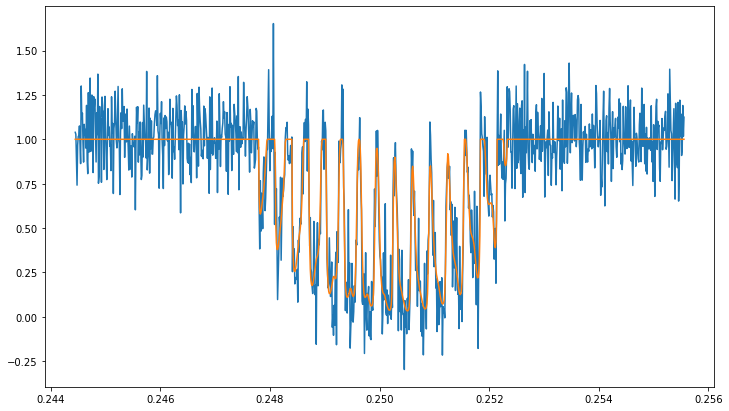

In [8]:
plt.figure(figsize=(12,7))
plt.plot(orbital_phase, injection + noise)
plt.plot(orbital_phase, injection, ls="-")
#plt.title('2020-06-25')
#plt.xlim(0.247, 0.253)
plt.show()

In [ ]:
# Set-up priors for model 1
parameters = dict(delta_phi_B=None, sigma=None)

priors = dict()
priors["delta_phi_B"] = bilby.core.prior.Uniform(0, 1, r"$\Delta\phi_{\rm B}$")
priors["sigma"] = bilby.core.prior.Uniform(0, 2, r"$\sigma_{\rm noise}$")

# Define the likelihood for model 1
likelihood = TailoredGaussianLikelihood(orbital_phase=orbital_phase, flux=fluxes, date="2019-06-25T00:00:00Z", 
                                        nu=1.4, parameters=parameters)

# Run sampling with dynesty
results = bilby.run_sampler(priors=priors, likelihood=likelihood, sampler="dynesty", nlive=1023,
                            outdir="./fit_test", label="test")

20:51 bilby INFO    : Running for label 'test', output will be saved to './fit_test'
20:51 bilby INFO    : Search parameters:
20:51 bilby INFO    :   delta_phi_B = Uniform(minimum=0, maximum=1, name='$\\Delta\\phi_{\\rm B}$', latex_label='$\\Delta\\phi_{\\rm B}$', unit=None, boundary=None)
20:51 bilby INFO    :   sigma = Uniform(minimum=0, maximum=2, name='$\\sigma_{\\rm noise}$', latex_label='$\\sigma_{\\rm noise}$', unit=None, boundary=None)
20:54 bilby INFO    : Single likelihood evaluation took 1.614e+00 s


0it [00:00, ?it/s]

20:54 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1023, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 613, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x11fd07310>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
20:54 bilby INFO    : Checkpoint every check_point_delta_t = 600s
20:54 bilby INFO    : Using dynesty version 1.0.1
20:54 bilby INFO    : Using the bilby-implemented rwalk sample

697it [1:14:24,  3.12s/it, bound:0 nc:  1 ncall:2.0e+03 eff:34.4% logz=-1562.59+/-0.11 dlogz:265.303>0.1]  

22:08 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1122it [1:39:16,  6.49s/it, bound:0 nc:  9 ncall:3.0e+03 eff:37.0% logz=-1431.83+/-0.10 dlogz:133.796>0.1]

22:33 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1392it [2:03:40,  4.33s/it, bound:0 nc:  3 ncall:4.0e+03 eff:34.5% logz=-1381.47+/-0.10 dlogz:83.119>0.1] 

22:57 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1593it [2:28:26,  9.57s/it, bound:0 nc:  7 ncall:5.0e+03 eff:31.6% logz=-1357.03+/-0.10 dlogz:58.449>0.1]

23:22 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1780it [2:52:43,  5.62s/it, bound:0 nc:  4 ncall:6.0e+03 eff:29.5% logz=-1339.81+/-0.10 dlogz:41.017>0.1]

23:46 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1936it [3:17:53, 17.46s/it, bound:0 nc: 26 ncall:7.1e+03 eff:27.4% logz=-1331.02+/-0.10 dlogz:32.062>0.1]

00:11 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
00:11 bilby INFO    : Writing 106 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2062it [3:42:17, 10.72s/it, bound:0 nc: 13 ncall:8.1e+03 eff:25.5% logz=-1324.60+/-0.10 dlogz:25.504>0.1]

00:36 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2183it [4:07:38,  8.07s/it, bound:0 nc:  6 ncall:9.1e+03 eff:24.0% logz=-1320.22+/-0.10 dlogz:21.000>0.1]

01:01 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
01:01 bilby INFO    : Writing 119 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2279it [4:32:28, 23.87s/it, bound:0 nc: 23 ncall:1.0e+04 eff:22.6% logz=-1317.65+/-0.09 dlogz:18.334>0.1]

01:26 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
01:26 bilby INFO    : Writing 120 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2375it [4:56:49, 15.09s/it, bound:0 nc: 11 ncall:1.1e+04 eff:21.4% logz=-1315.39+/-0.09 dlogz:15.973>0.1]

01:50 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
01:50 bilby INFO    : Writing 128 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2462it [5:21:21, 43.06s/it, bound:0 nc: 48 ncall:1.2e+04 eff:20.3% logz=-1313.49+/-0.09 dlogz:13.990>0.1]

02:15 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
02:15 bilby INFO    : Writing 144 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2556it [5:46:32, 18.22s/it, bound:0 nc: 17 ncall:1.3e+04 eff:19.5% logz=-1311.82+/-0.09 dlogz:12.221>0.1]

02:40 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
02:40 bilby INFO    : Writing 167 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2649it [6:11:30, 17.58s/it, bound:0 nc: 19 ncall:1.4e+04 eff:18.8% logz=-1310.32+/-0.09 dlogz:10.636>0.1]

03:05 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
03:05 bilby INFO    : Writing 176 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2723it [6:36:13, 42.24s/it, bound:0 nc: 70 ncall:1.5e+04 eff:18.0% logz=-1309.26+/-0.09 dlogz:9.497>0.1] 

03:30 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
03:30 bilby INFO    : Writing 184 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2794it [7:00:48, 33.82s/it, bound:0 nc: 51 ncall:1.6e+04 eff:17.3% logz=-1308.35+/-0.09 dlogz:8.517>0.1]

03:54 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
03:54 bilby INFO    : Writing 184 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2866it [7:25:47, 21.19s/it, bound:0 nc: 14 ncall:1.7e+04 eff:16.7% logz=-1307.56+/-0.09 dlogz:7.657>0.1]

04:19 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
04:19 bilby INFO    : Writing 237 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2921it [7:50:19, 20.04s/it, bound:0 nc: 12 ncall:1.8e+04 eff:16.1% logz=-1307.02+/-0.09 dlogz:7.058>0.1]

04:44 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
04:44 bilby INFO    : Writing 239 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2972it [8:15:43, 46.81s/it, bound:0 nc: 64 ncall:1.9e+04 eff:15.5% logz=-1306.54+/-0.09 dlogz:6.532>0.1]

05:09 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
05:09 bilby INFO    : Writing 243 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3013it [8:39:51, 23.48s/it, bound:0 nc:  3 ncall:2.0e+04 eff:14.9% logz=-1306.20+/-0.09 dlogz:6.148>0.1]

05:33 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
05:33 bilby INFO    : Writing 263 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3069it [9:06:17, 55.48s/it, bound:0 nc: 89 ncall:2.1e+04 eff:14.4% logz=-1305.77+/-0.09 dlogz:5.667>0.1]

06:00 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
06:00 bilby INFO    : Writing 275 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3110it [9:31:07, 19.37s/it, bound:0 nc:  8 ncall:2.2e+04 eff:14.0% logz=-1305.49+/-0.09 dlogz:5.350>0.1]

06:25 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
06:25 bilby INFO    : Writing 281 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3152it [9:56:00, 27.61s/it, bound:0 nc: 25 ncall:2.3e+04 eff:13.5% logz=-1305.24+/-0.09 dlogz:5.054>0.1]

06:50 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
06:50 bilby INFO    : Writing 292 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3197it [10:20:50, 29.15s/it, bound:0 nc: 16 ncall:2.4e+04 eff:13.2% logz=-1304.99+/-0.09 dlogz:4.761>0.1]

07:14 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
07:14 bilby INFO    : Writing 301 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3234it [10:45:47, 36.83s/it, bound:0 nc: 16 ncall:2.5e+04 eff:12.8% logz=-1304.80+/-0.09 dlogz:4.539>0.1]

07:39 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
07:39 bilby INFO    : Writing 325 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3273it [11:11:43, 53.76s/it, bound:0 nc: 88 ncall:2.6e+04 eff:12.4% logz=-1304.61+/-0.09 dlogz:4.314>0.1]

08:05 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
08:05 bilby INFO    : Writing 324 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3304it [11:37:01, 82.11s/it, bound:0 nc:105 ncall:2.7e+04 eff:12.1% logz=-1304.47+/-0.09 dlogz:4.144>0.1]

08:31 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
08:31 bilby INFO    : Writing 353 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3345it [12:01:37, 44.17s/it, bound:0 nc: 31 ncall:2.8e+04 eff:11.8% logz=-1304.30+/-0.09 dlogz:3.936>0.1]

08:55 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
08:55 bilby INFO    : Writing 353 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3392it [12:26:44, 39.65s/it, bound:0 nc: 24 ncall:2.9e+04 eff:11.5% logz=-1304.11+/-0.09 dlogz:3.713>0.1]

09:20 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
09:20 bilby INFO    : Writing 375 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3429it [12:51:32, 32.12s/it, bound:0 nc: 17 ncall:3.0e+04 eff:11.3% logz=-1303.98+/-0.09 dlogz:3.546>0.1]

09:45 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
09:45 bilby INFO    : Writing 377 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3457it [13:16:15, 76.39s/it, bound:0 nc: 89 ncall:3.1e+04 eff:11.0% logz=-1303.88+/-0.09 dlogz:3.425>0.1]

10:10 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
10:10 bilby INFO    : Writing 353 current samples to ./fit_test/test_samples.dat
/Users/other/miniconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


3476it [13:30:54, 40.82s/it, bound:0 nc: 34 ncall:3.2e+04 eff:10.9% logz=-1303.82+/-0.09 dlogz:3.346>0.1]

10:25 bilby INFO    : Run interrupted by signal 2: checkpoint and exit on 130
10:25 bilby INFO    : Written checkpoint file ./fit_test/test_resume.pickle
10:25 bilby INFO    : Writing 294 current samples to ./fit_test/test_samples.dat
